In [1]:
import json
from collections import Counter, defaultdict, deque
import gc

import numpy as np
import pandas as pd
import glob
import time
from tqdm import tqdm

from sklearn import model_selection, metrics
import matplotlib.pyplot as plt
import seaborn as sn

import lightgbm as lgb


#import riiideducation

In [2]:
import feather

In [3]:
question = pd.read_csv("/home/pocket/input/questions.csv")
question.head(2)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81


In [4]:
question["tags"].astype(str).apply(lambda x: len(x.split())).describe()

count    13523.000000
mean         2.291873
std          1.369772
min          1.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          6.000000
Name: tags, dtype: float64

<AxesSubplot:>

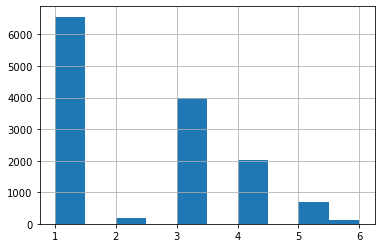

In [5]:
question["tags"].astype(str).apply(lambda x: len(x.split())).hist()

In [6]:
train = pd.read_feather("./train_sorted.feather")

In [7]:
print(train.columns)

# no lectures for now
train = train[train["answered_correctly"] != -1]

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'max_time_stamp', 'rand_time_stamp', 'virtual_time_stamp'],
      dtype='object')


In [8]:
u_cnt = Counter()
u_ac_cnt = Counter()
u_prev_ts = {}
uc_prev_ts = {}
ub_prev_ts = {}
u_ac_sum, u_qm_sum = Counter(), Counter()
u_ok_qm_sum, u_ng_qm_sum = Counter(), Counter()
u_ok_cnt, u_ng_cnt = Counter(), Counter()
up_ac_cnt, up_ac_sum = Counter(), Counter()
ulr_ac_cnt, ulr_ac_sum = Counter(), Counter()
uca_ac_cnt, uca_ac_sum = Counter(), Counter()
prev_utd, prev_ubtd = {}, {}
u_ac_roll = defaultdict(lambda: deque(maxlen=20))
uca_ac_sum, uca_ac_cnt = Counter(), Counter()
ut_ac_sum, ut_ac_cnt = Counter(), Counter()

def update_ac_values(prev_rows, prev_acs, prev_uas):
    #for i, row in enumerate(prev_df.values):
    for i, row in enumerate(prev_rows):
        update_ac_value(row, prev_acs[i], prev_uas[i])
    
def update_ac_value(row, prev_ac, prev_ua):
    uid = row[2]
    cid = row[3]
    contents = contents_dict[cid]
    qm = contents["q_ac_mean"]
    part = contents["part"]
    lr = part < 5
    upid = (uid, part)
    ulr = (uid, lr)
    ca = contents["correct_answer"]
    uca = (uid, ca)
    tags = contents["tags"].split()
    
    u_ac_cnt[uid] += 1
    u_ac_sum[uid] += prev_ac
    up_ac_cnt[upid] += 1
    up_ac_sum[upid] += prev_ac
    ulr_ac_cnt[ulr] += 1
    ulr_ac_sum[ulr] += prev_ac
    u_ac_roll[uid].append(prev_ac)
    uca_ac_cnt[uca] += 1
    uca_ac_sum[uca] += prev_ac
    
    for tag in tags:
        ut = (uid, tag)
        ut_ac_sum[ut] += prev_ac
        ut_ac_cnt[ut] += 1
    
    if prev_ac > 0.5:
        u_ok_cnt[uid] += 1
        u_ok_qm_sum[uid] += qm
    else:
        u_ng_cnt[uid] += 1
        u_ng_qm_sum[uid] += qm

def make_row(row, data_list, is_train=True):
    ts = row[1]
    uid = row[2]
    cid = row[3]
    tcid = row[5]
    if is_train:
        et = row[8]
        pqhe = row[9]
    else:
        et = row[6]
        pqhe = row[7]
    ucid = (uid, cid)
    utcid = (uid, tcid)
    contents = contents_dict[cid]
    bid = contents["bundle_id"]
    part = contents["part"]
    lr = part < 5
    ubid = (uid, bid)
    upid = (uid, part)
    ulr = (uid, lr)
    ca = contents["correct_answer"]
    uca = (uid, ca)
    tags = contents["tags"].split()
    
    output = {}
    if is_train:
        output["ac"] = row[7]
    #output["ts"] = ts
    #output["uid"] = uid
    #output["cid"] = cid
    #output["tcid"] = tcid
    output["et"] = et
    #output["pqhe"] = pqhe
    content_col = [
        "q_ac_mean", "q_ac_cnt", "q_et_mean", "q_et_cnt", "q_et_std", "b_ac_mean", "b_ac_cnt",
        "part", "correct_answer",
        "q_ok_uac_mean", "q_ok_uac_std", "q_ng_uac_mean", "q_ng_uac_std",
    ]
    for c in content_col:
        output[c] = contents[c]
        
    utd = u_prev_ts.get(uid, np.nan) - ts
    u_prev_ts[uid] = ts
    
    ubtd = ub_prev_ts.get(ubid, np.nan) - ts
    if ubtd < 0 or np.isnan(ubtd):
        output["ub_td2"] = ubtd
        prev_ubtd[0] = ubtd
    else:
        output["ub_td2"] = prev_ubtd[0]
    ub_prev_ts[ubid] = ts
    
    if utd < 0 or np.isnan(utd):
        output["u_td2"] = utd
        prev_utd[uid] = utd
    else:
        output["u_td2"] = prev_utd.get(uid, np.nan)
        
    u_cnt[uid] += 1
    u_qm_sum[uid] += contents["q_ac_mean"]
    output["u_cnt"] = u_cnt[uid]
    output["u_ac_cnt"] = u_ac_cnt[uid]
    output["u_ac_mean"] = (u_ac_sum[uid] / u_ac_cnt[uid]) if u_ac_cnt[uid] != 0 else np.nan
    output["uca_ac_mean"] = (uca_ac_sum[uca] / uca_ac_cnt[uca]) if uca_ac_cnt[uca] != 0 else np.nan
    output["u_qm_mean"] = u_qm_sum[uid] / u_cnt[uid]
    
    output["up_ac_cnt"] = up_ac_cnt[upid]
    output["up_ac_mean"] = (up_ac_sum[upid] / up_ac_cnt[upid]) if up_ac_cnt[upid] != 0 else np.nan
    output["ulr_ac_mean"] = (ulr_ac_sum[ulr] / ulr_ac_cnt[ulr]) if ulr_ac_cnt[ulr] != 0 else np.nan
    output["u_ok_qm_mean"] = (u_ok_qm_sum[uid] / u_ok_cnt[uid]) if u_ok_cnt[uid] != 0 else np.nan
    output["u_ng_qm_mean"] = (u_ng_qm_sum[uid] / u_ng_cnt[uid]) if u_ng_cnt[uid] != 0 else np.nan
    
    output["u_ac_mean20"] = sum(u_ac_roll[uid]) / len(u_ac_roll[uid]) if len(u_ac_roll[uid]) != 0 else np.nan
    
    ut_sum = 0
    ut_cnt = 0
    ut_mean = []
    for tag in tags:
        ut = (uid, tag)
        ut_sum += ut_ac_sum[ut]
        ut_cnt += ut_ac_cnt[ut]
        if ut_ac_cnt[ut] != 0:
            ut_mean.append(ut_ac_sum[ut]/ut_ac_cnt[ut])
    output["ut_ac_mean"] = (ut_sum / ut_cnt) if ut_cnt != 0 else np.nan
    output["ut_ac_mean2"] = sum(ut_mean) / len(ut_mean) if len(ut_mean) != 0 else np.nan
    
    data_list.append(output)
    return data_list


In [9]:
# content_train = train[:50*1000*1000].copy()
# train = train[50*1000*1000:]


# q_col = ["question_id", "bundle_id"]
# content_train = pd.merge(
#     content_train, question[q_col], left_on="content_id", right_on="question_id", how="left"
# )

# # contents features
# # there are no new contents in the test, so we use part of the train as the pseudo-training set
# temp = content_train.groupby("content_id")["answered_correctly"].agg(["mean", "count"])
# temp.columns = ["q_ac_mean", "q_ac_cnt"]
# temp2 = content_train.groupby("content_id")["prior_question_elapsed_time"].agg(["mean", "count", "std"])
# temp2.columns = ["q_et_mean", "q_et_cnt", "q_et_std"]
# # temp3 = content_train.groupby("content_id")["timestamp_diff"].agg(["mean", "std", "min", "max", "skew"])
# # temp3.columns = ["q_td_mean", "q_td_std", "q_td_min", "q_td_max", "q_td_skew"]
# temp4 = content_train.groupby("bundle_id")["answered_correctly"].agg(["mean", "count"])
# temp4.columns = ["b_ac_mean", "b_ac_cnt"]
# q_col = ["question_id", "bundle_id", "part"]
# #q_col += [str(i) for i in range(188)]
# contents = pd.merge(question[q_col], temp, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp2, left_on="question_id", right_on="content_id", how="left")
# #contents = pd.merge(contents, temp3, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp4, on="bundle_id", how="left")
# print(contents.head(2))
# print(contents.shape)
# merge_col = [
#     "question_id", "q_ac_mean", "q_ac_cnt", "q_et_mean",
#     "q_et_cnt", "q_et_std", "b_ac_mean", "b_ac_cnt"
# ]
# contents = contents[merge_col]
# contents = contents.set_index("question_id")
# contents_dict = contents.to_dict("index")
# print(len(contents_dict))

In [10]:
# with open("./contents_dict.pkl", "wb") as handle:
#     pickle.dump(contents_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# print(len(contents_dict))

In [11]:
import pickle
with open("./contents_dict_full2.pkl", "rb") as handle:
    contents_dict = pickle.load(handle)
print(len(contents_dict))

13523


In [30]:
# cnt = 0
# for k, v in contents_dict.items():
#     try:
#         v["tags"].split()
#         cnt += 1
#     except Exception:
#         print(v["tags"])
#         print(cnt)
    

In [31]:
#content_train = train[:50*1000*1000].copy()
#train = train[50*1000*1000:]

In [12]:
print(len(train))

99271300


In [45]:
class SingleLgb:
    def __init__(self, seed=99, dry_run=False):
        self.train_param = self.get_param()
        if dry_run:
            self.num_rounds = 100
        else:
            self.num_rounds = 500

    def do_train_direct(self, x_train, x_test, y_train, y_test):
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_eval = lgb.Dataset(x_test, y_test)

        # print('Start training...')
        model = lgb.train(self.train_param,
                          lgb_train,
                          valid_sets=[lgb_eval],
                          verbose_eval=100,
                          num_boost_round=self.num_rounds,
                          early_stopping_rounds=100,
                          #categorical_feature=[]
                         )
        # print('End training...')
        return model

    @staticmethod
    def show_feature_importance(model, filename=None):
        fi = pd.DataFrame({
            "name": model.feature_name(),
            "importance_split": model.feature_importance(importance_type="split").astype(int),
            "importance_gain": model.feature_importance(importance_type="gain").astype(int),
        })
        fi = fi.sort_values(by="importance_gain", ascending=False)
        print(fi)
        #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            #print(df)

    @staticmethod
    def get_param():
        return {
            'num_leaves': 127,
            'min_data_in_leaf': 100,
            'objective': 'binary',
            #'metric': 'auc',
            'metric': 'binary_logloss',
            'max_depth': -1,
            'learning_rate': 0.1,
            "boosting": "gbdt",
            "feature_fraction": 0.9,
            "verbosity": -1,
            "random_state": 83,
        }
    
class SingleTrainer:
    def __init__(self, pred_col, dry_run=False):
        self.pred_col = pred_col
        self.target_col = "ac"
        self.dry_run = dry_run
        self.val_size = 4*1000*1000

    def train_model(self, df):
        X = df[self.pred_col]
        y = df[self.target_col]
        
        models, scores = list(), list()
        for fold in range(4):
            print("---------")
            print("fold=", fold)
            f, c = fold, self.val_size
            val_s, val_e = -c-f*c, len(df)-f*c
            train_idx = -c-f*c
            X_train, X_val = X.iloc[:train_idx], X.iloc[val_s:val_e]
            y_train, y_val = y.iloc[:train_idx], y.iloc[val_s:val_e]
            print(X_train.shape, X_val.shape)
            
            lgbm = SingleLgb(seed=99, dry_run=self.dry_run)
            model = lgbm.do_train_direct(X_train, X_val, y_train, y_val)
            score = model.best_score["valid_0"]["binary_logloss"]
            pred = model.predict(X_val)
            score = metrics.roc_auc_score(y_val, pred)
            print("AUC=", score)
            if fold == 0:
                lgbm.show_feature_importance(model)
            models.append(model)
            scores.append(score)
            break
        return models, np.mean(scores)

In [14]:
train_data_list = list()
utcid_set = set()
prev_rows, prev_acs, prev_uas = list(), list(), list()
#init_values()

not_updated_idx = 0
for i, row in enumerate(tqdm(train.values)):
#     if i < 56597670:
#         continue
#     if i > 56597680:
#         break
    uid = row[2]
    tcid = row[5]
    utcid = (uid, tcid)
    if utcid not in utcid_set:
        if len(prev_rows) > 0:
            update_ac_values(prev_rows, prev_acs, prev_uas)
            prev_rows.clear()
            prev_acs.clear()
            prev_uas.clear()
            utcid_set.clear()
            not_updated_idx = i
    prev_rows.append(row)
    prev_acs.append(row[7])
    prev_uas.append(row[6])
    utcid_set.add(utcid)
        
    make_row(row, train_data_list, True)
        

start_time = time.time()
df = pd.DataFrame(train_data_list)
end_time = time.time()
print(end_time - start_time)
print(df.head(2))
#print(df.info())

100%|██████████| 99271300/99271300 [1:02:59<00:00, 26262.50it/s]


1046.3120143413544
   ac       et  q_ac_mean  q_ac_cnt     q_et_mean  q_et_cnt      q_et_std  \
0   1      NaN   0.966869     19619  23471.402344      5406  16817.431721   
1   1  16000.0   0.954815     21733  19462.746094     21732  10070.528940   

   b_ac_mean  b_ac_cnt  part  ...  uca_ac_mean  u_qm_mean  up_ac_cnt  \
0   0.966869     19619     1  ...          NaN   0.966869          0   
1   0.954815     21733     1  ...          1.0   0.960842          1   

   up_ac_mean  ulr_ac_mean  u_ok_qm_mean  u_ng_qm_mean  u_ac_mean20  \
0         NaN          NaN           NaN           NaN          NaN   
1         1.0          1.0      0.966869           NaN          1.0   

   ut_ac_mean  ut_ac_mean2  
0         NaN          NaN  
1         1.0          1.0  

[2 rows x 30 columns]


In [13]:
del train_data_list
gc.collect()

43

In [14]:
print("hi")

hi


In [17]:
# %%timeit
# df = pd.DataFrame(data_list)
# 24.7 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [15]:
df.to_feather("./temp_df.feather")

In [16]:
df.columns

Index(['ac', 'et', 'q_ac_mean', 'q_ac_cnt', 'q_et_mean', 'q_et_cnt',
       'q_et_std', 'b_ac_mean', 'b_ac_cnt', 'part', 'correct_answer',
       'q_ok_uac_mean', 'q_ok_uac_std', 'q_ng_uac_mean', 'q_ng_uac_std',
       'ub_td2', 'u_td2', 'u_cnt', 'u_ac_cnt', 'u_ac_mean', 'uca_ac_mean',
       'u_qm_mean', 'up_ac_cnt', 'up_ac_mean', 'ulr_ac_mean', 'u_ok_qm_mean',
       'u_ng_qm_mean', 'u_ac_mean20', 'ut_ac_mean', 'ut_ac_mean2'],
      dtype='object')

In [23]:
df = pd.read_feather("./temp_df.feather")

In [18]:
pred_col = ['ts',  'q_ac_mean', 'q_ac_cnt',
    'q_et_mean', 'q_et_cnt', 'q_et_std', 'b_ac_mean', 'b_ac_cnt', 'u_td',
       'uc_td','u_prev_qm', 'u_cnt',
       'u_qm_mean', 'u_et_mean', 'u_ac_mean', 
            "et", 
           # 'uid', 'cid', 'tcid', 'et',
            #'pqhe', 
             #'u_prev_ac', 'uc_prev_ac', 'u_prev_ua', 
]
print(pred_col)
pred_col = [
    'q_ac_mean', 'q_ac_cnt', 'q_et_mean', 'q_et_cnt', 'q_et_std', 'b_ac_mean', 'b_ac_cnt',
    'u_cnt', 'u_qm_mean', 'u_ac_mean', 'et', "ub_td2"
]

['ts', 'q_ac_mean', 'q_ac_cnt', 'q_et_mean', 'q_et_cnt', 'q_et_std', 'b_ac_mean', 'b_ac_cnt', 'u_td', 'uc_td', 'u_prev_qm', 'u_cnt', 'u_qm_mean', 'u_et_mean', 'u_ac_mean', 'et']


In [39]:
light_col = [
    'q_ac_mean', 'q_ac_cnt', 'q_et_mean', 'q_et_cnt', 'q_et_std', 'b_ac_mean', 'b_ac_cnt',
    'u_cnt', 'u_qm_mean', 'u_ac_mean', 'et', "ub_td2"
]
new_light_col = [
    'u_ok_qm_mean', 'u_ng_qm_mean',
    "up_ac_mean", "uca_ac_mean", #"u_ac_mean20", 
    #"ut_ac_mean", "ut_ac_mean2",
    "q_ng_uac_mean","q_ok_uac_mean", 
    "u_td2", 
    #"ub_cnt", "ubb_cnt",
    #"up_ac_cnt", "u_ac_cnt",
    "correct_answer", "ulr_ac_mean"
]
pred_col = light_col + new_light_col

In [17]:
# show_col = ["ub_td2"]
# df[show_col].describe()
#min=-8.655624e+12

,ub_td2
count,1.238109e+07
mean,-3.436013e+05
std,7.622211e+05
min,-8.655624e+06
25%,-2.681390e+05
50%,-4.577000e+04
75%,-5.261000e+03
max,-1.000000e+00


In [19]:
# df["ub_td_z"] = df["ub_td2"]//10*1000

In [46]:
#temp_df = df[1*1000*1000:].copy()
#temp_df = df.copy()
trainer = SingleTrainer(pred_col, dry_run=False)
models, score = trainer.train_model(df)

---------
fold= 0
(95271300, 21) (4000000, 21)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.525162
[200]	valid_0's binary_logloss: 0.523281
[300]	valid_0's binary_logloss: 0.522562
[400]	valid_0's binary_logloss: 0.522127
[500]	valid_0's binary_logloss: 0.52177
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.52177
AUC= 0.789792419539984
              name  importance_split  importance_gain
0        q_ac_mean              3920         65570864
9        u_ac_mean              3118         10549950
11          ub_td2              3847          8848453
14      up_ac_mean              2643          6035949
5        b_ac_mean              2306          5548728
13    u_ng_qm_mean              3291          5079565
18           u_td2              6518          5055451
20     ulr_ac_mean              2099          4621171
16   q_ng_uac_mean              4836          3007290
17   q_ok_uac_mean              4760

In [ ]:
#standard way
#[1000]	valid_0's auc: 0.782993

#periodic initialization
#0.730-2

#with u_ac_mean
#0.762

#with uc_td
#has 0.776ish

#with U_et_cnt(reset-cnt)
#same

#with uc_ac_prev
#0.777ish

#without
#[1000]	valid_0's auc: 0.765165

# with full row  feature
#[1000]	valid_0's auc: 0.765111

# with full cdict
#[1000]	valid_0's auc: 0.765448

# dropping td by //10*1000 decrease score by 0.001

# new feats from test_features=0.785 ->?0.7897

print("done")

In [37]:
data_tuple =(u_cnt, u_ac_cnt, u_ac_sum, u_qm_sum, u_prev_ts,
     u_ok_qm_sum, u_ng_qm_sum, u_ok_cnt, u_ng_cnt,
     up_ac_cnt, up_ac_sum, prev_utd, prev_ubtd,
     ulr_ac_cnt, ulr_ac_sum, uca_ac_sum, uca_ac_cnt,
     #ut_ac_sum, ut_ac_cnt
     #u_ac_roll,         
                )

In [26]:
for i in range(20):
    print(type(data_tuple[i]))

<class 'collections.Counter'>
<class 'collections.Counter'>
<class 'dict'>
<class 'collections.Counter'>
<class 'collections.Counter'>
<class 'collections.Counter'>
<class 'collections.Counter'>
<class 'collections.Counter'>
<class 'collections.Counter'>
<class 'collections.Counter'>
<class 'collections.Counter'>
<class 'dict'>
<class 'dict'>
<class 'collections.Counter'>
<class 'collections.Counter'>
<class 'collections.Counter'>
<class 'collections.Counter'>
<class 'collections.Counter'>
<class 'collections.Counter'>


IndexError: tuple index out of range

In [38]:
import pickle

with open("./data_tuple.pkl", "wb") as handle:
    pickle.dump(data_tuple, handle, pickle.HIGHEST_PROTOCOL)

In [ ]:
!gsutil cp ./data_tuple.pkl gs://dena-ai-training-24-gcp/riiid/data_tuple.pkl

In [47]:
models[0].save_model("./model_s83.lgb")

In [21]:
with open("./ub_prev_ts.pkl", "wb") as handle:
    pickle.dump(ub_prev_ts, handle, pickle.HIGHEST_PROTOCOL)

In [ ]:
!zip -r /home/imported.zip ../imported

  adding: ../imported/ (stored 0%)
  adding: ../imported/riid-model-1-sub-2e22c046-1dd5-465b-acab-86bce5acc113-Copy1.ipynb (deflated 71%)
  adding: ../imported/contents_dict_50m_seed3.pkl (deflated 62%)
  adding: ../imported/riid-model-1-sub-2e22c046-1dd5-465b-acab-86bce5acc113.ipynb (deflated 74%)
  adding: ../imported/data_tuple.pkl (deflated 55%)
  adding: ../imported/train.feather

In [ ]:
!gsutil cp /home/imported.zip gs://dena-ai-training-24-gcp/riiid/imported.zip

In [ ]:
def make_pred_df(df):
    pred_data_list = list()
    for i, row in enumerate(df.values):
        make_row(row, pred_data_list, False)
    pred_df = pd.DataFrame(pred_data_list)
    return pred_df

In [ ]:
env = riiideducation.make_env()
is_train = False
init_values()

In [ ]:
prev_df = None
for (test_df, sample_prediction_df) in env.iter_test():
    #show_col = ["row_id", "user_id", "content_type_id", "prior_group_answers_correct", "prior_group_responses"]
    #print(test_df.head(2))
    #print(sample_prediction_df.head(2))
    prev_ac = eval(test_df.iloc[0]["prior_group_answers_correct"])
    prev_ua = eval(test_df.iloc[0]["prior_group_responses"])
    use_df = test_df[test_df['content_type_id'] == 0]
    #print("--------------------")
    
    if len(prev_ac) > 0:
        update_ac_values(prev_df.values, prev_ac, prev_ua)
    pred_df = make_pred_df(use_df)
    #print(pred_df.head(2))
    pred = models[0].predict(pred_df[pred_col])
    prev_df = use_df
    
    sub_df = use_df[["row_id"]].copy()
    sub_df["answered_correctly"] = pred
    env.predict(sub_df)
    #test_df['answered_correctly'] = 0.5
    #env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])


#print(pred_df.columns)
